# Regresión logística

## Índice
1. **[¿Qué es la regresión logística?](#1.-¿Qué-es-la-regresión-logística?)**


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             roc_curve, roc_auc_score)

from mglearn.datasets import make_forge
from mglearn.plots import plot_2d_separator, plot_2d_classification
from mglearn import discrete_scatter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
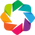

In [2]:
import holoviews as hv
hv.extension("bokeh")

## [1.](#Índice) ¿Qué es la regresión logística?

Para hacer clasificación lineal podemos usar algoritmos diferentes a los vistos anteriormente. Entre estos algoritmos encontramos la regresión logística. A pesar del nombre, **NO sirve para hacer regresión y solo se usa para clasificación**.

![linear to logistic](./imgs/LR_model_diagram.png)

Normalmente se usa para hacer clasificación binaria, aunque se puede extender (la regresión logística y otros algoritmos de clasificación binaria) a clasificación multiclase como luego veremos.

Este caso es similar a lo que vimos anteriormente, tenemos lo siguiente:

$$ \hat{y}(x) = w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $$

Salvo que en este caso sumaremos una constante al output de nuestro modelo lineal de la siguiente forma:

$$ P(y=1|x) = b + w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $$

Donde **$x_i$ representa cada una de las features** de nuestro ejemplo, y **$w_i$ representa un vector de pesos**. Por eso, además de encontrar un peso para cada una de las features, nuestro modelo tendrá un parámetro adicionar que corresponderá a sumar una constante.

Esta constante sumada al output de un modelo lineal se llama **intercept**.



Y nuestras clases las podemos definir como:

$$ clase_{1} = 1 \space si \space P(y=1|x)\ge 0.5 $$
$$ clase_{0} = 0 \space si \space P(y=1|x)\lt 0.5 $$

<div class="alert alert-warning">
Las clases da igual como las definamos, pueden ser "Sí" y "No" o "No" y "Sí", es decir, simplemente tiene que ser coherente con la pregunta.

¿Es azul? Sí -> 0 / No -> 1

¿Es azul? Sí -> 1 / No -> 0
</div>

En este caso, ¿cuál sería una buena función de pérdida?

Lo que queremos son probabilidades que nos digan si algo es más probable que esté en una clase o en otra. Para ello se usa la función logística o sigmoide (por su forma en ese):

$$ S(x_i) = \frac{1}{1+e^{-x_i}} $$


¿Usamos el error cuadrático medio como en el caso de la regresión lineal?

![linear to logistic](./imgs/13_linear_vs_logistic_regression.webp)

## Implementación de la regresión logística

<div class="alert alert-danger">
Falta especificar que creo datos y EDA
</div>

In [3]:
X, y = make_forge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
X.__class__.__name__

'ndarray'

Los pintamos para ver cómo son:

<div class="alert alert-info">
holoviews plot con mas anotaciones
</div>

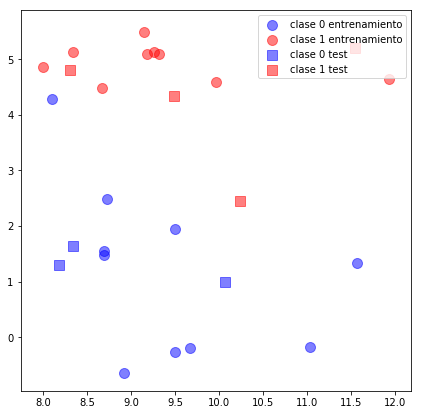

In [5]:
fig, ax = plt.subplots(figsize=(7,7))

idx = y_train == 0
ax.scatter(X_train[idx, 0], X_train[idx, 1], color='b', s=100, label="clase 0 entrenamiento", alpha=0.5)
ax.scatter(X_train[~idx, 0], X_train[~idx, 1], color='r', s=100, label="clase 1 entrenamiento", alpha=0.5)

idx = y_test == 0
ax.scatter(X_test[idx, 0], X_test[idx, 1], color='b', s=100, marker="s", label="clase 0 test", alpha=0.5)
ax.scatter(X_test[~idx, 0], X_test[~idx, 1], color='r', marker="s", s=100, label="clase 1 test", alpha=0.5)
plt.legend(loc="upper right")

Con toda esta chicha vamos a construir nuestro algoritmo de regresión logística y evaluar como funciona sobre los datos creados:

In [6]:
class RegLog:
    """
    Modelo de regresión logistica.
    
    Este modelo solo puede usarse para clasificación binaria (clases {1, 0}). \
     Una vez entrenado, modela la probabilidad de que un ejemplo pertenezca a la clase 1. 
     
     Puede ser usado para predecir la probabilidad de pertenecer a la clase uno, o para
     predecir directamente la clase asignada a cada ejemplo.
    """
    def __init__(self, learning_rate: float = 0.001, num_iters: int = 50_000):
        """
        Inicializa una instancia de Reglog. 
        
        Args:
            learning_rate: Este valor define cuanto va a actualizarse el model con su \
                           correspondiente gradiente en cada iteración de entrenamiento.
            num_iters: Número de iteraciones  que se van a llevar a cabo para \
                        entrenar el modelo.
        """
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.weights = None # Será un vector de longitud igual al numero de features + 1.
    
    def __repr__(self) -> str:
        string = "{}\n".format(self.__class__.__name__)
        if self.weights is None:
            string += "Modelo no entrenado."
        else:
            w_columns = ["weight_{}: {:.4f} ".format(i, w) for i, w in enumerate(self.weights[1:])]
            string += "".join(w_columns)
            string += "intercept: {:.4f}".format(self.weights[0])
        return string
        
    @staticmethod
    def sigmoid(linear_output: np.ndarray) -> np.ndarray:
        """
        Aplica la función sigmoide a cada uno de los valores del array de entrada.

        Args:
            linear_output: Corresponde a la predicción de un modelo lineal.

        Returns:
            Aray que contiene el resultado de aplicar la función sigmoide al \
            valor de entrada.
        """
        return 1 / (1 + np.exp(-linear_output))

    @staticmethod
    def log_likelihood(sigmoid_output, y: np.ndarray) -> np.ndarray:
        """
        Función de log-likehood que puede usarse para cuantificar el error del modelo.

        Args:
            sigmoid_output: Predicción del modelo en forma de probabilidad.
            y: Valor real correspondiente a cada predicción realizada por el modelo.

        Returns:
            Logaritmo de la función de verosimilitud correspondiente a los valores de entrada.
        """
        return (-y * np.log(sigmoid_output) - (1 - y) * np.log(1 - sigmoid_output)).mean()
    
    def predict_prob(self, X: np.ndarray) -> np.ndarray:
        """
        Para cada ejemplo, predice la probabilidad de pertenecer a la clase 1.

        Args:
            X: Dataset que se desea clasificar. Cada ejemplo corresponde a una \
               fila (dimensión 0 del array), y cada feature a una columna \
               (dimensión 1 del array).

        Returns:
            Array que contiene las probabilidades assignadas a cada ejemplo de pertenecer a la
            clase 1. Este vector contiene floats en el intervalo [0, 1].
        """
        # El efecto del intercept es sumar una constante a la predicción lineal del modelo.
        # Al aplicar el producto escalar el peso asignado al intercept se multiplica por 1, 
        # lo cual equivale a sumar el peso, pero es más eficiente de calcular.
        intercept = np.ones((X.shape[0], 1))
        x = np.concatenate((intercept, X), axis=1)
        return self.sigmoid(np.dot(x, self.weights))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predice la classe a la que pertenecen cada uno de los ejemplos de X.

        Args:
            X: Dataset que se desea clasificar. Cada ejemplo corresponde a una \
               fila (dimensión 0 del array), y cada feature a una columna \
               (dimensión 1 del array).

        Returns:
            Devuelve un array unidmiensional que contiene las predicciones para cada ejemplo de X.
            Este vector solo puede contener los valores {0, 1}
        """
        return self.predict_prob(X).round()

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Entrena el modelo de regresión logística.

        Args:
            X_train: Dataset de entrenamiento. Este array contiene \
               las features como columnas y los ejemplos de \
               entrenamiento como filas.

            y_train: Classes a las que pertenecen los ejemplos \
               del dataset de entrenamiento codificadas como \
               1 o 0. Cada elemento de este vector corresponde \
               al ejemplo x con el mismo índice. (Un elemento por \
               cada fila de x)
        """        
        self._initialize_weights(X_train)
        for i in range(self.num_iters):
            self.training_iteration(X_train, y_train)

    def training_iteration(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Actualiza los pesos del modelo realizando una iteración del algoritmo gradient descend.
        """
        prediction = self.predict_prob(X_train)
        loss = self.log_likelihood(prediction, y_train)
        # Guardar estos valores es un truco para calcular el gradiente mas eficientemente.
        self._prediction, self._y_train, self._X_train = prediction, y_train, X_train
        # En general, el gradiente se calcula derivando la función 
        # de pérdida usando la regla de la cadena.
        loglike_gradient = self._calculate_gradient(loss)
        self.weights -= self.learning_rate * loglike_gradient
    
    def _initialize_weights(self, X: np.ndarray) -> None:
        """Inicializa los pesos del modelo."""
        n_features = X.shape[1]
        self.weights = np.zeros(n_features + 1) # El + 1 corresponde al peso de intercept.        

    def _calculate_gradient(self, loss: np.ndarray) -> np.ndarray:
        """
        Devuelve el gradiente de la función log likelihood.

        Args:
            loss: Función de coste que va a derivarse. Será ignorado porque utilizaremos un truco \
                  matemático que no requiere del valor de la función de loss, y que es mas 
                  eficiente de calcular.

        Returns:
            Array que contiene el gradiente de loss.
        """
        # Con un poco de matemáticas, podemos darnos cuenta de que el gradiente del 
        # log-likelihood no es más que la multiplicación de la matriz de entradas transpuesta (X.T)
        # por el error de la predicción.
        intercept = np.ones((self._X_train.shape[0], 1))
        X = np.concatenate((intercept, self._X_train), axis=1)
        gradient = np.dot(X.T, (self._prediction - self._y_train)) / self._y_train.size
        return gradient


Instanciamos nuestra clase recien creada.

In [7]:
reglog = RegLog(num_iters=10000)
reglog

RegLog
Modelo no entrenado.

In [8]:
from code_utils import RegLogTrainingPlotter
plot = RegLogTrainingPlotter(reglog, plot_every=250)
plot.create_plot()

:Layout
   .DynamicMap.I  :DynamicMap   []
      :NdOverlay   [Variable]
         :Curve   [index]   (value)
   .DynamicMap.II :DynamicMap   []
      :Bars   [index,Variable]   (value)

In [9]:
plot.fit(X_train, y_train, X_test, y_test)
plot

RegLog
weight_0: -0.5086 weight_1: 1.4269 intercept: -0.1590

Predecimos con nuestro modelo ajustado los valores de prueba para ver si se parecen a las etiquetas:

In [10]:
y_pred = reglog.predict(X_test)

In [11]:
for i, (yi, yyi, x0, x1) in enumerate(zip(y_pred, y_test, X_test[:,0], X_test[:,1])):
    print("Example", i, "prediction", int(yi), "True value", yyi, "Feature_0", x0, "feature_1", x1)

Example 0 prediction 1 True value 1 Feature_0 11.541558067580805 feature_1 5.211160831287977
Example 1 prediction 0 True value 0 Feature_0 10.063938389021391 feature_1 0.9907805507446118
Example 2 prediction 1 True value 1 Feature_0 9.49123468580826 feature_1 4.332247924903151
Example 3 prediction 0 True value 0 Feature_0 8.18378051935439 feature_1 1.2956421365969786
Example 4 prediction 1 True value 1 Feature_0 8.309888627451462 feature_1 4.80623965645751
Example 5 prediction 0 True value 1 Feature_0 10.240289482051844 feature_1 2.4554440066887393
Example 6 prediction 0 True value 0 Feature_0 8.344687849166668 feature_1 1.6382434918057587


Vamos a comparar con lo que trae `scikit-learn`. Instanciamos:

In [12]:
logreg = LogisticRegression(C=1e20, fit_intercept=False)

Ajustamos:

In [13]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Predecimos:

In [14]:
y_pred = logreg.predict(X_test)

In [15]:
for yi, yyi in zip(y_pred, y_test):
    print(int(yi), yyi)

1 1
0 0
1 1
0 0
1 1
0 1
0 0


Parece que lo que obtenemos es similar a nuestro algoritmo de más arriba. Vamos a ver los pesos que obtenemos:

In [16]:
print(logreg.intercept_, logreg.coef_)

0.0 [[-0.69783202  1.84116287]]


In [17]:
clf = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
from code_utils import plot_model_output
plot_model_output(clf, X_train, y_train)

:Overlay
   .QuadMesh.I :QuadMesh   [x,y]   (z)
   .Scatter.I  :Scatter   [x]   (y,target,porb)
   .Curve.I    :Curve   [x]   (y)

Se parecen bastante. Podéis modificar la tasa de aprendizaje o el número de iteraciones para ver si mejora o empeora.

## Más detalles y cosas interesantes

En la instancia de más arriba de `LogisticRegression` estoy usando un parámetro que le llama `C`. Este hiperparámetro es el que regula la regularización. Por defecto, la regresión logística en `scikit-learn` usa regularización L2 y valores más altos de `C` llevan a quitarle importancia a la regularización (al revés que con el $\alpha$ de la regressión *Ridge* o la regresión Lasso). Por eso, en el ejemplo de más arriba he usado `C=1e20` para que la regularización fuese poco importante ya que en nuestro algoritmo no hemos incluido regularización para simplificar las cosas...

Vamos a usar el modelo que implementa `scikit-learn` con los valores por defecto:

<div class="alert alert-danger">
Falta especificar que creo datos y EDA
</div>

In [19]:
logreg = LogisticRegression()

In [20]:
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, 
    cancer.target, 
    stratify=cancer.target, 
    random_state=42
)

In [22]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Varias cosas de las que se ven ahí arriba. 

* El *solver* es lo que realiza la optimización. Podéis leer más sobre ello aquí: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html. En el caso de scikit-learn usa *solvers* especializados. Más info aquí: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

* `C` es el parámetro que regula la regularización. Un valor bajo regulariza mucho mientras que un valor muy alto le quita importancia a la regularización.

* `class_weight` nos permite dar más peso a alguna clase (acordáos de los datos desnivelados o descompensados (*imbalanced datasets*).

* `penalty` define el tipo de regularización. Dependiendo del *solver* se podrán usar unos tipos de regularizaciones u otros.

* ...

Como veis, hay muchas cosas que se pueden toquetear y que llevarán a resultados diferentes. Dependiendo de los datos que tengamos tendrá sentido usar unas cosas u otras.

Como se puede ver, los algoritmos de clasificación lineales guardan muchas similitudes con los algoritmos de regresión lineales.

## Evaluación del modelo

Ya hemos hablado de la matriz de confusión. Vamos a ver como se ven los modelos usando la matriz de confusión:

In [23]:
logreg01 = LogisticRegression(C=0.1).fit(X_train, y_train)
logreg10 = LogisticRegression(C=10).fit(X_train, y_train)

y_pred01 = logreg01.predict(X_test)
y_pred10 = logreg10.predict(X_test)

mc01 = confusion_matrix(y_test, y_pred01)
mc10 = confusion_matrix(y_test, y_pred10)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
print(mc01)
print(mc10)

[[46  7]
 [ 1 89]]
[[49  4]
 [ 1 89]]


In [244]:
from bokeh.models import HoverTool
def plot_confussion_matrix(y_test, y_pred, var_names: list=None, cmap: str="YlGnBu",
                          width=500, height: int=400, title: str="Confusion matrix",
                          normalize: bool=False):
    value_label = "examples"
    target_label = "true_label"
    pred_label = "predicted_label"
    label_color = "color"

    def melt_distances_to_heatmap(distances: pd.DataFrame) -> pd.DataFrame:
        dist_melt = pd.melt(distances.reset_index(), value_name=value_label, id_vars="index")
        dist_melt = dist_melt.rename(columns={"index": target_label, "variable": pred_label})
        dist_melt[target_label] = pd.Categorical(dist_melt[target_label])
        dist_melt[pred_label] = pd.Categorical(dist_melt[pred_label])
        coords = dist_melt.copy()
        coords[target_label] = dist_melt[target_label].values.codes
        coords[pred_label] = dist_melt[pred_label].values.codes
        print(coords.columns)
        return coords[[pred_label, target_label, value_label]]
    
    conf_matrix = confusion_matrix(y_test, y_pred01)
    if normalize:
        conf_matrix = np.round(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], 3)
    # Adjust label color to make them readable when displayed on top of any colormap
    df = melt_distances_to_heatmap(pd.DataFrame(conf_matrix))
    mean = df[value_label].mean()
    df[label_color] = -df[value_label].apply(lambda x: int(x > mean))
    if var_names is not None:
        df[target_label] = df[target_label].apply(lambda x: var_names[x])
        df[pred_label] = df[pred_label].apply(lambda x: var_names[x])
    true_label_name = "Actual label"
    pred_label_name = "Predicted label"
    
    tooltip = [(true_label_name, "@{%s}" % target_label),
               (pred_label_name, "@{%s}" %  pred_label),
               ("Examples", "@{%s}" % value_label)]
    hover = HoverTool(tooltips=tooltip)
    heatmap = hv.HeatMap(df, kdims=[pred_label, target_label])
    heatmap.opts(title=title, colorbar=True, cmap=cmap,
                 width=width, height=height, tools=[hover])
    labeled = heatmap * hv.Labels(heatmap).opts(text_color=label_color, cmap=cmap)
    return labeled.options(xlabel=pred_label_name, ylabel=true_label_name, invert_yaxis=True)

In [241]:
target_label = "pene grande"
"@{%s}" % target_label

'@{pene grande}'

Como vemos, la clase 0 se asigna a los cánceres malignos. Sabiendo esto vamos a dibujar la matriz de confusión:

In [243]:
plot_confussion_matrix(y_test, y_pred01, normalize=False, var_names=cancer.target_names)

Index(['true_label', 'predicted_label', 'examples'], dtype='object')


:Overlay
   .HeatMap.I :HeatMap   [predicted_label,true_label]   (examples,color)
   .Labels.I  :Labels   [predicted_label,true_label]   (examples,color)

<div class="alert alert-danger">
Falta crear funcion de matrix de confusion
</div>

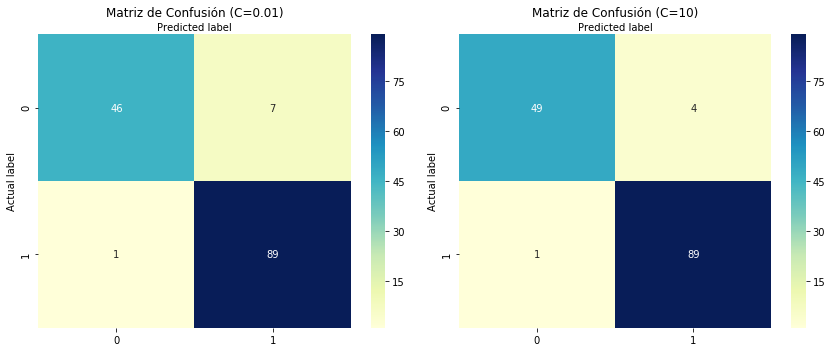

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].set_xticks([0, 1])
axs[0].set_yticks([0, 1])
sns.heatmap(pd.DataFrame(mc01), annot=True, cmap="YlGnBu" ,fmt='g', ax=axs[0])
axs[0].xaxis.set_label_position("top")
axs[0].set_title('Matriz de Confusión (C=0.01)', y=1.1)
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

axs[1].set_xticks([0, 1])
axs[1].set_yticks([0, 1])
sns.heatmap(pd.DataFrame(mc10), annot=True, cmap="YlGnBu" ,fmt='g', ax=axs[1])
axs[1].xaxis.set_label_position("top")
axs[1].set_title('Matriz de Confusión (C=10)', y=1.1)
axs[1].set_ylabel('Actual label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()

En el caso anterior hemos conseguido, regularizando menos, reducir el número de falsos negativos. En casos como estos, donde un falso positivo requeriría hacer más pruebas y luego descartar el problema, un falso negativo es un problema mucho más grave ya que se puede mandar a una persona a casa con un cáncer maligno habiéndole dicho que está todo correcto. En estos casos hemos de ver qué es lo que nos interesa optimizar mejor. Igual nos da un poco más igual tener falsos positivos pero es inaceptable tener falsos negativos.

Vamos a analizar más métricas:

In [27]:
print("Caso C=0.01")
print("Accuracy:",accuracy_score(y_test, y_pred01))
print("Precision:",precision_score(y_test, y_pred01))
print("Recall:",recall_score(y_test, y_pred01))

print("Caso C=10")
print("Accuracy:",accuracy_score(y_test, y_pred10))
print("Precision:",precision_score(y_test, y_pred10))
print("Recall:",recall_score(y_test, y_pred10))

Caso C=0.01
Accuracy: 0.9440559440559441
Precision: 0.9270833333333334
Recall: 0.9888888888888889
Caso C=10
Accuracy: 0.965034965034965
Precision: 0.956989247311828
Recall: 0.9888888888888889


En el caso anterior nos interesaría que nuestras métricas optimizasen el caso de evitar mandar a gente enferma a casa ya que le dejar a sanos en el hospital puede ser un incordio más aceptable.

Existen más métricas interesantes. Podéis mirar en:

* https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation

* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

## Clasificación multiclase

Hay algoritmos de clasificación que no permiten la clasificación multiclase. La regresión logística es una excepción. Una técnica común para poder usar un algoritmo que solo permite clasificación binaria a un algoritmo con capacidad de clasificación multiclase es usar la estrategia "Uno contra el Resto" (*One-Vs-Rest*). La estrategia "Uno contra el Resto" no es más que etiquetar la clase que queremos clasificar (por ejemplo con un 1) contra el resto de clases (todas tendrán clase, por ejemplo, 0). De tal forma que tendremos tantos modelos de clasificación binaria como clases queramos clasificar. Para hacer una predicción todos los clasificadores binarios se ejecutan usando un punto de prueba. El clasificador que tiene el *score* más alto en su clase será el "ganador" y esa clase se devuelve como el resultado de la predicción.

Vamos a ver esto con un ejemplo para ver si se entiende mejor:

In [28]:
X, y = make_blobs(random_state=42)

Vamos a dibujar estos datos a ver cómo se ven:

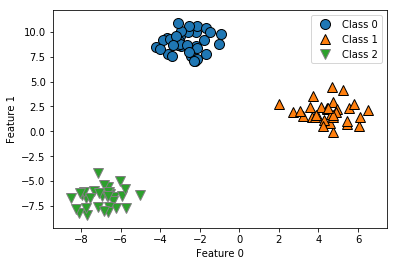

In [29]:
fig, ax = plt.subplots()
discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.legend(["Class 0", "Class 1", "Class 2"])

Entrenamos una regresión logística:

In [30]:
logreg = LogisticRegression(multi_class="ovr").fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
print("Coef dims: ", logreg.coef_.shape)
print("Intercept dims: ", logreg.intercept_.shape)

Coef dims:  (3, 2)
Intercept dims:  (3,)


Vemos que está usando 3 clases y dos *features* (lo que tenemos en el *dataset*). Vamos a ver las líneas que define cada uno de los tres conjuntos:

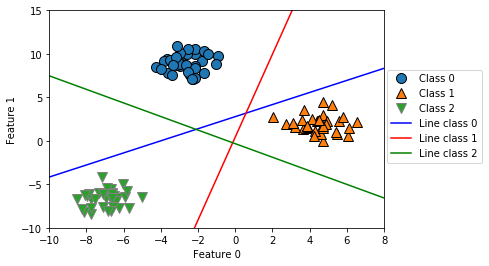

In [32]:
fig, ax = plt.subplots()

discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(logreg.coef_, logreg.intercept_, ['b', 'r', 'g']):
    ax.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
    ax.set_ylim(-10, 15)
    ax.set_xlim(-10, 8)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
ax.legend(['Class 0', 'Class 1', 'Class 2', 
           'Line class 0', 'Line class 1','Line class 2'], 
           loc=(1.01, 0.3))

Cada línea muestra la región donde la clase se define como propia o "resto".

Pero ¿qué pasa con la región del medio que ninguna clase define como propia?

Si un punto cae en ese triángulo, ¿a qué clase pertenecerá?

Pues será la clase que tenga el valor más alto, es decir, la clase con la línea más próxima.

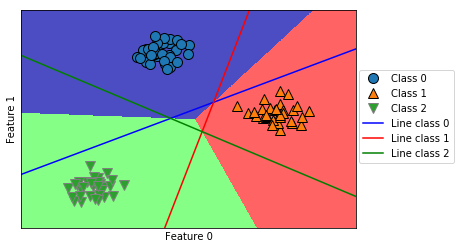

In [33]:
fig, ax = plt.subplots()

plot_2d_classification(logreg, X, fill=True, alpha=.7, ax=ax)
discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(logreg.coef_, logreg.intercept_, ['b', 'r', 'g']):
    ax.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
    ax.legend(['Class 0', 'Class 1', 'Class 2', 
               'Line class 0', 'Line class 1', 'Line class 2'], 
               loc=(1.01, 0.3))
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

## Otros modelos lineales de clasificación

Le podéis echar un ojo a `LinearSVC` o a `SGDClassifier` u otros en `sklearn.linear_models`. Del primero comentaremos cosas más adelante. Del segundo comentamos cosas usándolo en regresión.

## Otros apuntes

El principal parámetro de los modelos lineales es el parámetro de regularización ($\alpha$ en los modelos de regresión lineales, como la regresión lineal, *Ridge* o Lasso, y `C` en los modelos de clasificación lineales, como la regresión logística, las máquinas de vectores soporte lineales o el clasificador de Gradiente descendiente estocástico. Otra decisión importante en los modelos lineales es el tipo de regularización que queremos usar, principalmente L1 o L2. Dependiendo del problema nos interesará más una estrategia u otra a la hora de seleccionar estos parámetros.

Los modelos lineales son muy rápidos de entrenar y en la predicción. Escalan muy bien a conjuntos de datos muy grandes. Otra fortaleza de los modelos lineales es que suele ser más fácil de ver cómo se obtienen las predicciones. Desafortunadamente no siempre es sencillo saber porqué los coeficientes son como son. Esto es especialmente importante si tus datos tienen dimensiones altamente correlacionadas (multicolinealidad) y será complicado interpretar los coeficientes.

Los modelos lineales, a menudo, se comportan bien cuando el número de dimensiones es largo comparado con el número de datos. También se usan en casos con gran cantidad de datos, principalmente, porque otros modelos no escalan igual de bien y en muchos casos no es posible usarlos. En casos de baja dimensionalidad otros modelos pueden resultar más interesantes puesto que pueden generalizar mejor.

## [Apéndice](#Índice) Desarrollo matemático

### [A.1](#Índice) Definición del modelo

¿Cómo llegamos a la función logística?

La probabilidad de que un ejemplo $x_i$ sea 1 debido a sus entradas se puede representar de la siguiente forma:

$$ P(y=1|x) $$

Si pensamos que eso se puede representar de forma lineal y tenemos n dimensiones, podríamos escribir algo como:

$ P(y=1|x) = w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $, donde ($ w_0 = b $ y $ x_0 = 1 $), es decir:

$$ P(y=1|x) = b + w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $$

Donde $x_i$ representa cada una de las features de nuestro ejemplo, por lo que además de encontrar un peso para cada una de las features, nuestro modelo tendrá un parámetro adicionar que corresponderá a sumar una constante.

Esta constante sumada al output de un modelo lineal se llama intercept.

### [A.2](#Índice) Derivando la funcion sigmoide a partir del ratio de probabilidades

El algoritmo de regresión podría ajustar esos pesos pero, como hemos visto en la gráfica de más arriba eso podría llevar a valores que van de $-\infty$ a $\infty$. Dado que queremos predecir probabilidades, que son valores entre 0. y 1. necesitamos encontrar una función capaz de mapear el output de nuestro modelo linea a ese intervalo.

El ratio de probabilidades (*odds ratio*) es un término que nos puede ayudar. Se define como la probabilidad de que suceda entre la probabilidad de que no suceda. Como nos encontramos en un caso binario, la probabilidad de que suceda es $p$ y la probabilidad de que no suceda es el resto hasta 1, $1-p$. Su ratio se representa así:

$$ odds(p) = \frac{p}{1-p}$$

Si representamos lo anterior para diferentes valores de $p$ tenemos la siguiente gráfica:

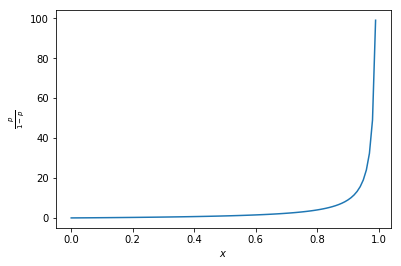

In [34]:
x = np.arange(0, 1, 0.01)
odds = x / (1 - x)

fig, ax = plt.subplots()

ax.plot(x, odds)
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\frac{p}{1-p}$");

Si $p=1$ nuestro ratio se dispara lo cual no es lo que queremos.

Podemos usar el logaritmo natural del ratio y nos da lo siguiente:

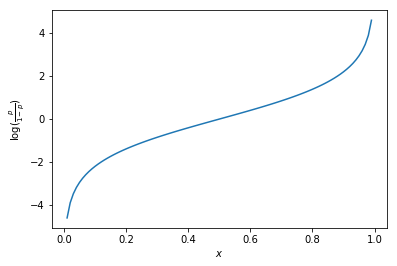

In [35]:
x = np.arange(0.01, 1, 0.01)
odds = np.log(x / (1 - x))

fig, ax = plt.subplots()

ax.plot(x, odds)
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\log(\frac{p}{1-p})$");

Como podemos mapear una combinación lineal de entradas arbitrarias a la función del logaritmo natural de los ratios podemos aprovechar eso para tener:

$$ log\_odds(P(y=1|x)) = w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $$

($ w_0 = b $ y $ x_0 = 1 $)

Si queremos la $ P(y=1|x) $ podemos buscar la inversa del logaritmo natural ($log\_odds$) para obtenerlo. Si nos aprovechamos de algunas identidades de logaritmos y exponenciales:

$$ y = log(\frac{x}{1-x}) $$

$$ x = log(\frac{y}{1-y}) $$

$$ e^x = \frac{y}{1-y} $$

$$y = (1-y)*e^x $$

$$ y = e^x - y*e^x $$

$$ y + ye^x = e^x $$

$$ y*(1 + e^x) = e^x $$

$$ y = \frac{e^x}{1+e^x} $$

$$ y = \frac{1}{\frac{1}{e^x} + 1} $$

$$ y = \frac{1}{1 + e^{-x}} $$

La última expresión es la inversa de $log\_odds$ y se parece mucho a la función logística o sigmoide (en realidad lo es...):

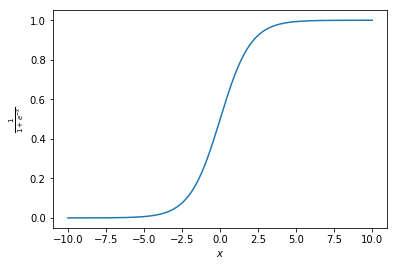

In [36]:
x = np.arange(-10, 10, 0.01)
inv_odds = 1 / (1 + np.exp(-x))

fig, ax = plt.subplots()

ax.plot(x, inv_odds)
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\frac{1}{1+e^{-x}}$");

Vaya, ahora todo se restringe a 0 y 1 en el eje *y*.

<div class="alert alert-success">
Explicar que es cada simbolo
</div>

Por tanto, volviendo al principio teníamos que:

$$ log\_odds(P(y=1|x)) = w_0 · x_0 + w_1 · x_1 + ... + w_n · x_n $$

($ w_0 = b $ y $ x_0 = 1 $)

Si simplificamos la notación tenemos:

$$ log\_odds(P(y=1|x)) = w^T·x $$

Si ahora, finalmente, sacamos la inversa de lo anterior nos quedará:

$$ P(y=1|x) = \frac{1}{1+e^{-w^T·x}} $$

## Estimadores de máxima verosimilitud

En inglés se conocen como *maximum likelihood estimators* (MLE). Es un método para obtener los parámetros de un modelo estadístico. El método obtiene los parámetros buscando los valores de los parámetros que maximizan la función de verosimilitud. Las estimaciones se conocen como estimadores de máxima verosimilitud.

Veamos como funciona esto en la práctica. Para ello vamos a usar la distribución normal:

$$ f(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} exp(\frac{-(x-\mu)^2}{2\sigma^2})  $$

La función de verosimilitud se obtiene de la siguiente forma:

$$ L(\mu, \sigma^2) = f(x_1, x:2,...,x_N|\mu, \sigma^2) = \prod_{i=1}^N f(x_i|\mu, \sigma^2) $$
$$ L(\mu, \sigma^2) = (\frac{1}{2\pi\sigma^2})^{(n/2)} exp(\frac{-\sum_{i=1}^N(x_i-\mu)^2}{2\sigma^2})$$

Lo que queremos hacer es maximizar lo anterior. En la expresión anterior tenemos multiplicaciones pero lo que se suele hacer normalmente es usar el logaritmo de la función de verosimilitud. Y en lugar de maximizar se minimiza usando el negativo del logaritmo de la función de verosimilitud:

$$ ll(\mu, \sigma^2) = \log(L(\mu, \sigma^2)) $$

$$ ll(\mu, \sigma^2) = \log((\frac{1}{2\pi\sigma^2})^{(n/2)} exp(\frac{-\sum_{i=1}^N(x_i-\mu)^2}{2\sigma^2})) $$

$$ nll(\mu, \sigma^2) = -\log(L(\mu, \sigma^2)) $$

$$ nll(\mu, \sigma^2) = -\log((\frac{1}{2\pi\sigma^2})^{(n/2)} exp(\frac{-\sum_{i=1}^N(x_i-\mu)^2}{2\sigma^2})) $$

<div class="alert alert-info">
**[INCISO]** Un breve paréntesis para anotar un par de propiedades de exponenciales y de logaritmos naturales:

$$ e^x · e ^y = e^{(x + y)} $$

$$ ln(x·y) = ln(x) + ln(y) $$

$$ ln(x/y) = ln(x) - ln(y) $$

$$ ln(x^y) = y·ln(x) $$
</div>

Seguimos con MLE...

Si desarrollamos la expresión anterior de $nll$ usando las propiedades de exponenciales y logaritmos nos queda:

$$ nll(\mu, \sigma^2) = -\log((\frac{1}{2\pi\sigma^2})^{(n/2)}) - (\frac{-\sum_{i=1}^N(x_i-\mu)^2}{2\sigma^2}) $$

$$ nll(\mu, \sigma^2) = -\frac{n}{2}\log(\frac{1}{2\pi\sigma^2}) - (\frac{-\sum_{i=1}^N(x_i-\mu)^2}{2\sigma^2}) $$

Para minimizar hemos de usar el gradiente e igualarlo a 0. Si derivamos con respecto a $\mu$:

$$ \frac{\partial{nll(\mu, \sigma^2)}}{\partial{\mu}} = 0 $$

$$ \frac{\partial{nll(\mu, \sigma^2)}}{\partial{\mu}} = \frac{\sum_{i=0}^{N}\mu -\sum_{i=0}^{N}x_i}{2\sigma^2}  = 0 $$

$$ \sum_{i=0}^{N}\mu -\sum_{i=0}^{N}x_i = 0 $$

$$ n·\mu -\sum_{i=0}^{N}x_i = 0 $$

$$ \mu = \frac{\sum_{i=0}^{N}x_i}{n} $$

De la misma forma, derivamos $nll$ con respecto a $\sigma$ e igualamos a 0:

$$ \frac{\partial{nll(\mu, \sigma^2)}}{\partial{\sigma}} = 0 $$

$$ \frac{\partial{nll(\mu, \sigma^2)}}{\partial{\sigma}} = \frac{n}{\sigma} - \frac{\sum_{i=1}^{N}(x_i-\mu)^2}{\sigma^3}= 0 $$

$$ \sigma^2 = \sum_{i=1}^{N}\frac{(x_i-\mu)^2}{n} $$

De esta forma obtendríamos los parámetros de la distribución normal.

Vamos a aplicar lo mismo ahora para el caso de la regresión logística:



La función de verosimilitud será (para una clasificación binaria) para un caso (un ejemplo $(x_i, y_i)$) será:

$$ L(\textbf{w})_i = p(x_i|\textbf{w})^{y_i} · (1-p(x_i|\textbf{w})^{1-y_i}) $$

Si lo generalizamos para los n casos (datos) tenemos la función de verosimilitud:

$$ L(\textbf{w}) = \prod_{i=1}^{N}p(x_i|\textbf{w})^{y_i} · (1-p(x_i|\textbf{w})^{1-y_i}) $$

El *log-likelihood* será:

$$ ll(\textbf{w}) = \sum_{i=1}^{N}({y_i}·\log(p(x_i|\textbf{w})) + {1-y_i}·\log(1-p(x_i|\textbf{w}))) $$

Si toqueteamos lo anterior llegaremos a lo siguiente (saltando pasos):

$$ ll = \sum_{i=1}^{N}y_{i}\textbf{w}^{T}x_{i} - log(1+e^{\textbf{w}^{T}x_{i}}) $$

Si de lo anterior sacamos el gradiente (saltamos pasos):

$$ \bigtriangledown ll = X^{T}(Y - \hat{Y}) $$

El gradiente del *log-likelihood* no es más que la multiplicación de la traspuesta de las entradas por el error de la predicción.

## Referencias

* http://karlrosaen.com/ml/notebooks/logistic-regression-why-sigmoid/

* Sección 4.4.1 de https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12.pdf

* https://github.com/martinpella/logistic-reg/blob/master/logistic_reg.ipynb

* https://beckernick.github.io/logistic-regression-from-scratch/

* https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python